In [1]:
%pylab inline
from qsystem_2 import PfbSoc, freq2reg
from tqdm import tqdm_notebook as tqdm
from qsystem2_asm import *
#from averager_program import AveragerProgram
#from slab.instruments import InstrumentManager
import time

Populating the interactive namespace from numpy and matplotlib


In [8]:
with ASM_Program() as p:
    p.add_pulse(ch=7, name="gauss",  style="arb", idata=gauss(mu=300, si=160, length=592, maxv=30000), qdata=None)
    
    
    p.memri(1, 1, 17)  # Get frequency value
    p.regwi(1, 2, 15000) #Set gain
    p.memri(1, 3, 18) # samples
    p.regwi(1,4,0x0) # b00000 -> phrst = 0, stdysel = 0, mode = 0, outsel = 00
    p.bitwi(1,4,4,"<<", 16)
    p.bitw (1,3,3,"|", 4)
    p.regwi(1,5,0)
    p.synci(200)
    
    p.regwi(0,1,0x4001)
    p.seti(0,0,1,0)
    
    p.memri (0,9,19) # sync length
    p.memri (0,4,33) # reps
    
    p.label("LOOP")
    p.set (6, 1, 1, 0, 0, 2, 3, 5)
    p.set (7, 1, 1, 0, 0, 2, 3, 5)
    
    p.mathi (1,2,2,"+",1000)
    p.sync (0, 9)
    p.loopnz (0,4,"LOOP")
    
    p.waiti(0,1000)
    p.read (0,3,"lower", 1) #Lower 32-bit on register $1 of page 3.
    p.read (0,3,"upper", 2)
    
    p.memwi (3,1,55)
    p.memwi (3, 2,56)
    
    p.seti(0,0,0,0)
    p.end()
p


// Program

      memri 1, $1, 17;
      regwi 1, $2, 15000;
      memri 1, $3, 18;
      regwi 1, $4, 0;
      bitwi 1, $4, $4 << 16;
      bitw 1, $3, $3 | $4;
      regwi 1, $5, 0;
      synci 200;
      regwi 0, $1, 16385;
      seti 0, 0, $1, 0;
      memri 0, $9, 19;
      memri 0, $4, 33;
LOOP: set 6, 1, $1, $0, $0, $2, $3, $5;
      set 7, 1, $1, $0, $0, $2, $3, $5;
      mathi 1, $2, $2, +, 1000;
      sync 0, $9;
      loopnz 0, $4, @LOOP;
      waiti 0, 1000;
      read 0, 3 lower $1;
      read 0, 3 upper $2;
      memwi 3, $1, 55;
      memwi 3, $2, 56;
      seti 0, 0, $0, 0;
      end ;

In [12]:
f"{16385:>016b}"

'0100000000000001'

In [13]:
bin(0x4001)

'0b100000000000001'

In [2]:
soc = PfbSoc('qsystem_2.bit')

In [8]:
fout = 200

with ASM_Program() as p:
    fout = p.reg2freq_adc(p.freq2reg_adc(fout))
    print (fout)
    
    p.add_pulse(ch=7, name="gauss",  style="arb", idata=gauss(mu=300, si=160, length=592, maxv=30000), qdata=None)
    
    p.pulse(ch=7, pulse="gauss", freq=p.freq2reg(fout), phase=0, gain=15000, t=0, play=False)
    p.synci(200)
    
    p.regwi(0,4, 7)
    
    p.trigger_adc(adc1=1, adc2=1,t=0)
    p.label("LOOP")
    p.pulse(7,play=True)
    
    p.sync_all(t=51)
    p.loopnz (0,4,"LOOP")
    
    p.waiti(0,1000)
    p.read (0,3,"lower", 1) #Lower 32-bit on register $1 of page 3.
    p.read (0,3,"upper", 2)
    
    p.memwi (3,1,55)
    p.memwi (3,2,56)
    
    p.end()
p

199.96875



// Program

      regwi 3, $16, 139788288;                  //freq = 199.96875 MHz
      regwi 3, $17, 0;                          //phase = 0
      regwi 3, $19, 15000;                      //gain = 15000
      regwi 3, $18, 0;                          //addr = 0
      regwi 3, $20, 524325;                     //stdysel | mode | outsel = 0b01000 | length = 37 
      synci 200;
      regwi 0, $4, 7;
      regwi 0, $31, 49152;                      //out = 0b1100000000000000
      seti 0, 0, $31, 256;                      //ch =0 out = $31 @t = 0
      regwi 0, $31, 0;                          //out = 0b0000000000000000
      seti 0, 0, $31, 266;                      //ch =0 out = $31 @t = 0
LOOP: regwi 3, $21, 0;                          //t = 0
      set 7, 3, $16, $17, $18, $19, $20, $21;   //ch = 7, out = $16,$18,$19,$20 @t = $21
      synci 88;
      loopnz 0, $4, @LOOP;
      waiti 0, 1000;
      read 0, 3 lower $1;
      read 0, 3 upper $2;
      memwi 3, $1, 55;
      memwi 3, $

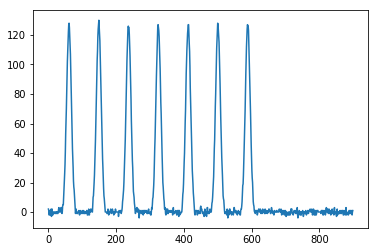

In [7]:
p.load_pulses(soc)

soc.tproc.stop()
soc.tproc.load_asm_program(p)

soc.readouts[0].set_out("product")
soc.readouts[0].set_freq(fout)
soc.avg_bufs[0].config(address=0, length=900)
soc.avg_bufs[0].enable()

soc.readouts[0].set_out("product")
soc.readouts[0].set_freq(fout)
soc.avg_bufs[0].config(address=0, length=900)
soc.avg_bufs[0].enable()

time.sleep(1)

# Start tProc.

soc.tproc.start()

time.sleep(1)

# Raw data.
[di_raw,dq_raw] = soc.get_decimated(ch=0, length=900)
plt.plot(di_raw)

# Accumulated data.
[di,dq] = soc.get_accumulated(ch=0, length=16)

